In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Working on {device}')

Working on cuda


In [3]:
data = pd.read_csv('concrete.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1, 1)

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [5]:
class MLP(nn.Module):
    def __init__(self, hidden_neurons):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(8, hidden_neurons)  # Camada oculta com número variável de neurônios
        self.output = nn.Linear(hidden_neurons, 1)  # Camada de saída
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.hidden(x))  # Ativação ReLU na camada oculta
        x = self.output(x)             # Saída linear
        return x

Hidden Neurons: 8, Weight Decay: 0.01, Validation Loss: 78.5122
Hidden Neurons: 8, Weight Decay: 0.001, Validation Loss: 74.3193
Hidden Neurons: 8, Weight Decay: 0.0001, Validation Loss: 137.9523
Hidden Neurons: 16, Weight Decay: 0.01, Validation Loss: 79.8887
Hidden Neurons: 16, Weight Decay: 0.001, Validation Loss: 57.6315
Hidden Neurons: 16, Weight Decay: 0.0001, Validation Loss: 64.2339
Hidden Neurons: 32, Weight Decay: 0.01, Validation Loss: 62.6496
Hidden Neurons: 32, Weight Decay: 0.001, Validation Loss: 48.2093
Hidden Neurons: 32, Weight Decay: 0.0001, Validation Loss: 49.4406
Hidden Neurons: 64, Weight Decay: 0.01, Validation Loss: 47.1699
Hidden Neurons: 64, Weight Decay: 0.001, Validation Loss: 52.7688
Hidden Neurons: 64, Weight Decay: 0.0001, Validation Loss: 47.3114
Hidden Neurons: 128, Weight Decay: 0.01, Validation Loss: 33.7642
Hidden Neurons: 128, Weight Decay: 0.001, Validation Loss: 43.9464
Hidden Neurons: 128, Weight Decay: 0.0001, Validation Loss: 44.8520

Melhores

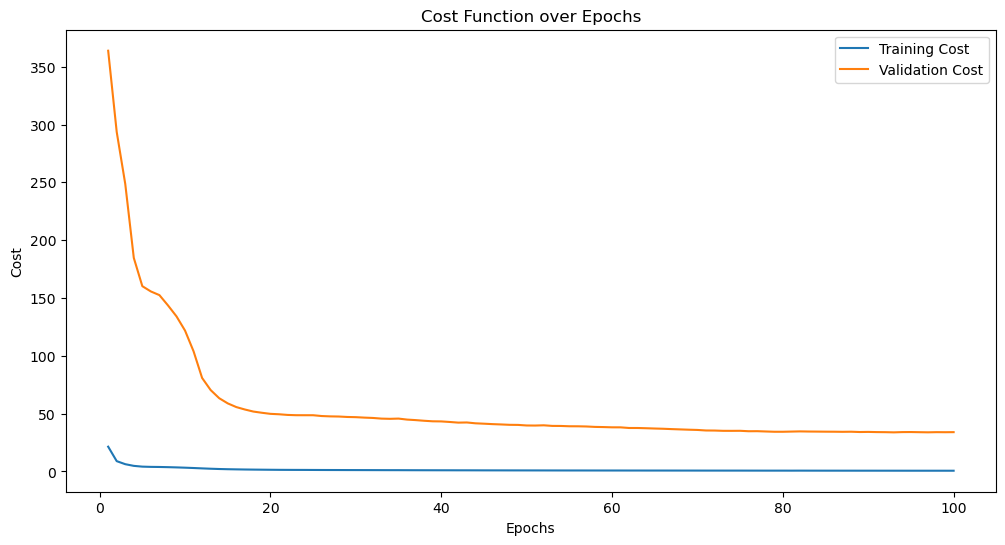

In [6]:
# Função para treinar o modelo e avaliar nos conjuntos de validação e teste
def train_and_evaluate(hidden_neurons, weight_decay, num_epochs=100, batch_size=32):
    model = MLP(hidden_neurons)
    criterion = nn.MSELoss()  # Critério de avaliação
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    best_model = None
    
    # Listas para armazenar os custos ao longo das épocas
    train_costs, val_costs = [], []
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_train_loss = 0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        # Custo médio no conjunto de treino
        avg_train_loss = epoch_train_loss / len(X_train)
        
        # Avaliação nos conjuntos de validação e teste
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val).item()
        
        train_costs.append(avg_train_loss)
        val_costs.append(val_loss)
        
        # Salvar o melhor modelo com base no menor custo de validação
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    return best_val_loss, best_model, train_costs, val_costs


hidden_neurons_options = [8, 16, 32, 64, 128]
weight_decay_options = [0.01, 0.001, 0.0001]

best_hyperparams = None
best_val_loss = float('inf')
best_model_state = None

for hidden_neurons, weight_decay in product(hidden_neurons_options, weight_decay_options):
    val_loss, model_state, train_costs, val_costs = train_and_evaluate(hidden_neurons, weight_decay)
    print(f'Hidden Neurons: {hidden_neurons}, Weight Decay: {weight_decay}, Validation Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = (hidden_neurons, weight_decay)
        best_model_state = model_state
        best_train_costs, best_val_costs = train_costs, val_costs

print(f'\nMelhores Hiperparâmetros -> Hidden Neurons: {best_hyperparams[0]}, Weight Decay: {best_hyperparams[1]}')

# 8. Plotar as curvas de custo ao longo das épocas
epochs = list(range(1, len(best_train_costs) + 1))
plt.figure(figsize=(12, 6))
plt.plot(epochs, best_train_costs, label='Training Cost')
plt.plot(epochs, best_val_costs, label='Validation Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost Function over Epochs')
plt.legend()
plt.show()

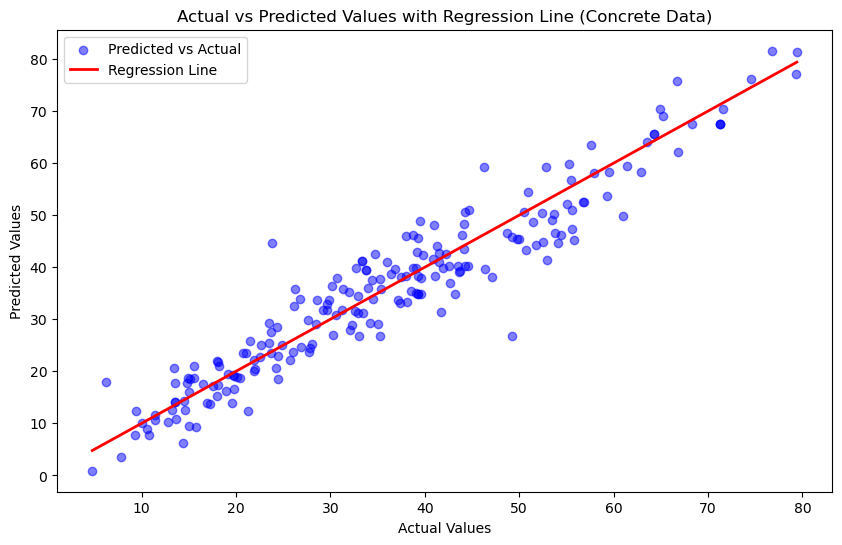

In [7]:
# Realizar predições no conjunto de teste
best_model = MLP(best_hyperparams[0])
best_model.load_state_dict(best_model_state)
with torch.no_grad():
    y_pred_test_concrete = best_model(X_test)

# Converte tensores para numpy arrays
y_test_np = y_test.numpy()
y_pred_test_np = y_pred_test_concrete.numpy()

# Gráfico de dispersão com a reta de regressão
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_test_np, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r-', linewidth=2, label='Regression Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values with Regression Line (Concrete Data)')
plt.legend()
plt.show()

In [8]:
# Treinar o melhor modelo no conjunto de treino completo e avaliar no conjunto de teste
best_model = MLP(best_hyperparams[0])
best_model.load_state_dict(best_model_state)

# Avaliação no conjunto de teste
best_model.eval()
with torch.no_grad():
    y_pred_train = best_model(X_train)
    y_pred_val = best_model(X_val)
    y_pred_test = best_model(X_test)

# Calcular métricas no conjunto de treino, validação e teste
criterion = nn.MSELoss()

epsilon = 1e-8  # Evitar divisão por zero

# Treino
rmse_train = torch.sqrt(criterion(y_pred_train, y_train)).item()
mae_train = torch.mean(torch.abs(y_pred_train - y_train)).item()
mre_train = torch.mean(torch.abs((y_pred_train - y_train) / (y_train + epsilon))).item()

# Validação
rmse_val = torch.sqrt(criterion(y_pred_val, y_val)).item()
mae_val = torch.mean(torch.abs(y_pred_val - y_val)).item()
mre_val = torch.mean(torch.abs((y_pred_val - y_val) / (y_val + epsilon))).item()

# Teste
rmse_test = torch.sqrt(criterion(y_pred_test, y_test)).item()
mae_test = torch.mean(torch.abs(y_pred_test - y_test)).item()
mre_test = torch.mean(torch.abs((y_pred_test - y_test) / (y_test + epsilon))).item()

print(f'\nTreino -> RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, MRE: {mre_train:.4f}')
print(f'Validação -> RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, MRE: {mre_val:.4f}')
print(f'Teste -> RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, MRE: {mre_test:.4f}')


Treino -> RMSE: 4.2041, MAE: 3.2521, MRE: 0.1170
Validação -> RMSE: 5.8258, MAE: 4.4315, MRE: 0.1363
Teste -> RMSE: 5.1100, MAE: 3.9677, MRE: 0.1378


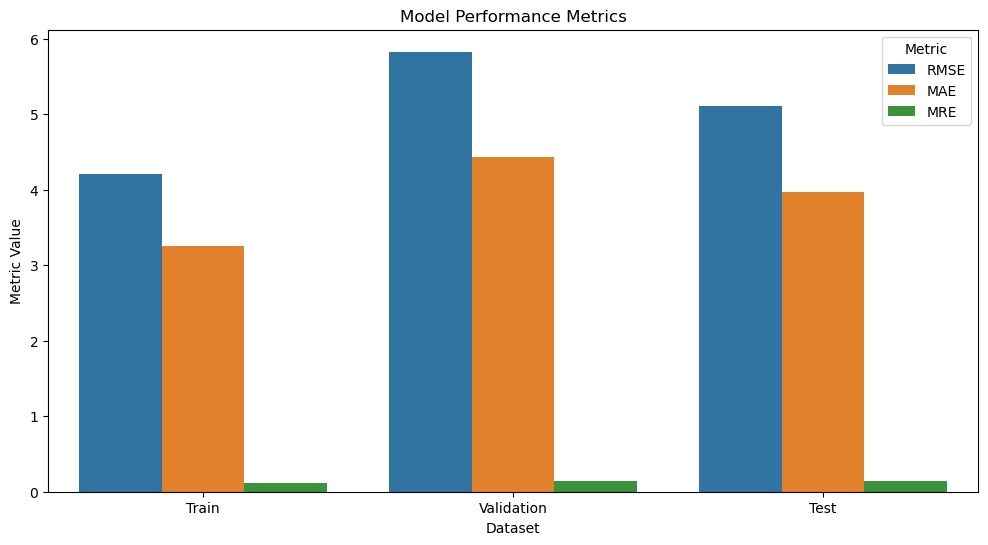

In [9]:
metrics = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'RMSE': [rmse_train, rmse_val, rmse_test],
    'MAE': [mae_train, mae_val, mae_test],
    'MRE': [mre_train, mre_val, mre_test]
}

metrics_df = pd.DataFrame(metrics)

# Plotar as métricas
plt.figure(figsize=(12, 6))
metrics_melted = pd.melt(metrics_df, id_vars=['Dataset'], var_name='Metric', value_name='Value')
sns.barplot(x='Dataset', y='Value', hue='Metric', data=metrics_melted)
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Dataset')
plt.show()

In [10]:
data = pd.read_csv('vowel.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1, 1)

In [11]:
# Normalizar as features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Codificar a variável de saída (fonema) usando One-Hot Encoding
encoder = OneHotEncoder()
y = encoder.fit_transform(y).toarray()

# Separar em conjuntos de treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Converter para tensores do PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_neurons, output_size):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_neurons)  # Camada oculta
        self.output = nn.Linear(hidden_neurons, output_size)  # Camada de saída
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.hidden(x))  # Ativação ReLU na camada oculta
        x = self.output(x)             # Saída linear
        return x

Hidden Neurons: 8, Weight Decay: 0.1, Validation Loss: 1.7928
Hidden Neurons: 8, Weight Decay: 0.01, Validation Loss: 0.8560
Hidden Neurons: 8, Weight Decay: 0.001, Validation Loss: 0.5620
Hidden Neurons: 8, Weight Decay: 0.0001, Validation Loss: 0.5780
Hidden Neurons: 16, Weight Decay: 0.1, Validation Loss: 1.7909
Hidden Neurons: 16, Weight Decay: 0.01, Validation Loss: 0.6677
Hidden Neurons: 16, Weight Decay: 0.001, Validation Loss: 0.4629
Hidden Neurons: 16, Weight Decay: 0.0001, Validation Loss: 0.3467
Hidden Neurons: 32, Weight Decay: 0.1, Validation Loss: 1.7912
Hidden Neurons: 32, Weight Decay: 0.01, Validation Loss: 0.6444
Hidden Neurons: 32, Weight Decay: 0.001, Validation Loss: 0.3091
Hidden Neurons: 32, Weight Decay: 0.0001, Validation Loss: 0.3149
Hidden Neurons: 64, Weight Decay: 0.1, Validation Loss: 1.7875
Hidden Neurons: 64, Weight Decay: 0.01, Validation Loss: 0.5989
Hidden Neurons: 64, Weight Decay: 0.001, Validation Loss: 0.2605
Hidden Neurons: 64, Weight Decay: 0.00

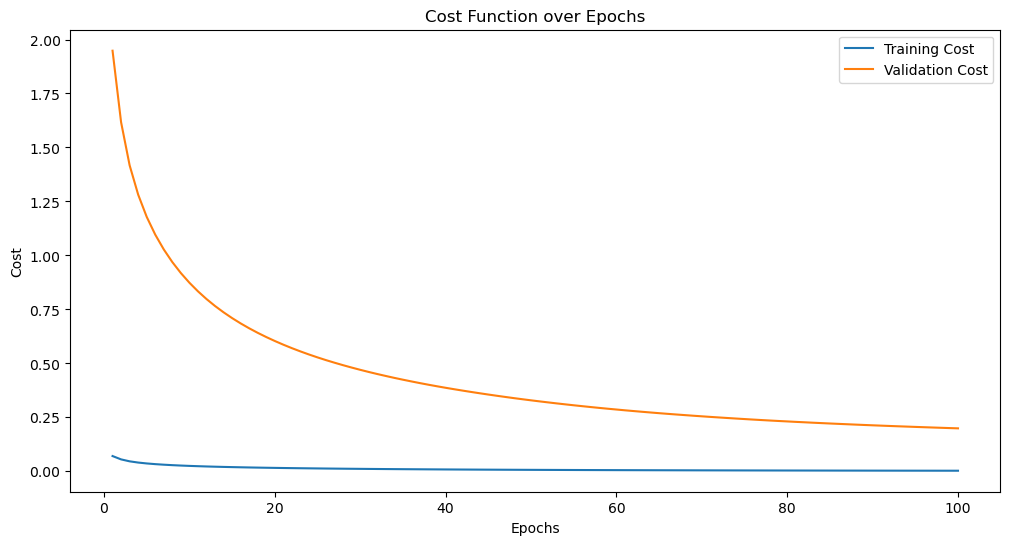

In [13]:
def train_and_evaluate(hidden_neurons, weight_decay, num_epochs=100, batch_size=32):
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    model = MLP(input_size, hidden_neurons, output_size)
    criterion = nn.CrossEntropyLoss()  # Critério de avaliação
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    best_model = None
    
    train_costs, val_costs = [], []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(X_train)
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        
        train_costs.append(avg_train_loss)
        val_costs.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    return best_val_loss, best_model, train_costs, val_costs

# Avaliação do modelo
hidden_neurons_options = [8, 16, 32, 64, 128, 256]
weight_decay_options = [0.1, 0.01, 0.001, 0.0001]

best_hyperparams = None
best_val_loss = float('inf')
best_model_state = None

for hidden_neurons, weight_decay in product(hidden_neurons_options, weight_decay_options):
    val_loss, model_state, train_costs, val_costs = train_and_evaluate(hidden_neurons, weight_decay)
    print(f'Hidden Neurons: {hidden_neurons}, Weight Decay: {weight_decay}, Validation Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = (hidden_neurons, weight_decay)
        best_model_state = model_state
        best_train_costs, best_val_costs = train_costs, val_costs

print(f'\nMelhores Hiperparâmetros -> Hidden Neurons: {best_hyperparams[0]}, Weight Decay: {best_hyperparams[1]}')

# Plotando as curvas de custo ao longo das épocas
epochs = list(range(1, len(best_train_costs) + 1))
plt.figure(figsize=(12, 6))
plt.plot(epochs, best_train_costs, label='Training Cost')
plt.plot(epochs, best_val_costs, label='Validation Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost Function over Epochs')
plt.legend()
plt.show()

In [14]:
# Treinar o melhor modelo no conjunto de treino completo e avaliar no conjunto de teste
best_model = MLP(X_train.shape[1], best_hyperparams[0], y_train.shape[1])
best_model.load_state_dict(best_model_state)

# Avaliação no conjunto de teste
best_model.eval()
with torch.no_grad():
    y_pred_train = best_model(X_train)
    y_pred_val = best_model(X_val)
    y_pred_test = best_model(X_test)

# Calcular a acurácia nos conjuntos de treino, validação e teste
y_pred_train_labels = torch.argmax(y_pred_train, dim=1).numpy()
y_train_labels = torch.argmax(y_train, dim=1).numpy()

y_pred_val_labels = torch.argmax(y_pred_val, dim=1).numpy()
y_val_labels = torch.argmax(y_val, dim=1).numpy()

y_pred_test_labels = torch.argmax(y_pred_test, dim=1).numpy()
y_test_labels = torch.argmax(y_test, dim=1).numpy()

accuracy_train = accuracy_score(y_train_labels, y_pred_train_labels)
accuracy_val = accuracy_score(y_val_labels, y_pred_val_labels)
accuracy_test = accuracy_score(y_test_labels, y_pred_test_labels)

print(f'\nAcurácia no Treino: {accuracy_train:.4f}')
print(f'Acurácia na Validação: {accuracy_val:.4f}')
print(f'Acurácia no Teste: {accuracy_test:.4f}')


Acurácia no Treino: 0.9966
Acurácia na Validação: 0.9495
Acurácia no Teste: 0.9444


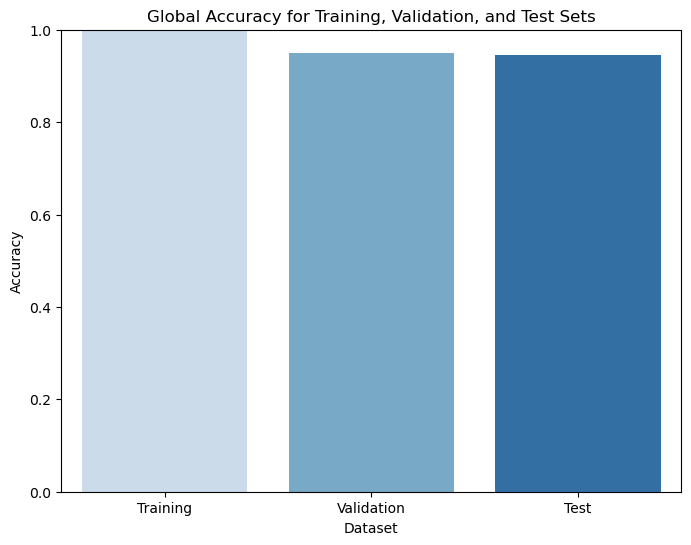

In [15]:
# Organizar as acurácias em um array
accuracy_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [accuracy_train, accuracy_val, accuracy_test]
}

# Converter para DataFrame
accuracy_df = pd.DataFrame(accuracy_data)

# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Dataset', y='Accuracy', data=accuracy_df, palette='Blues')
plt.title('Global Accuracy for Training, Validation, and Test Sets')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


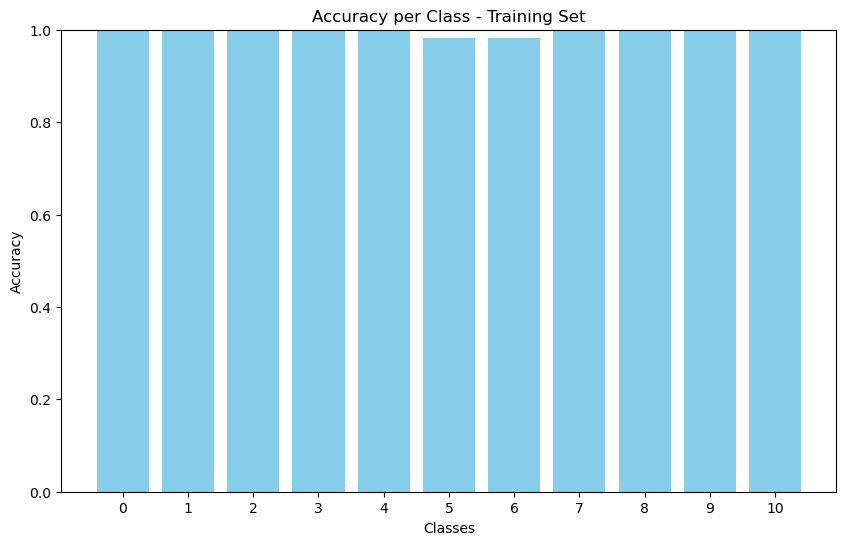

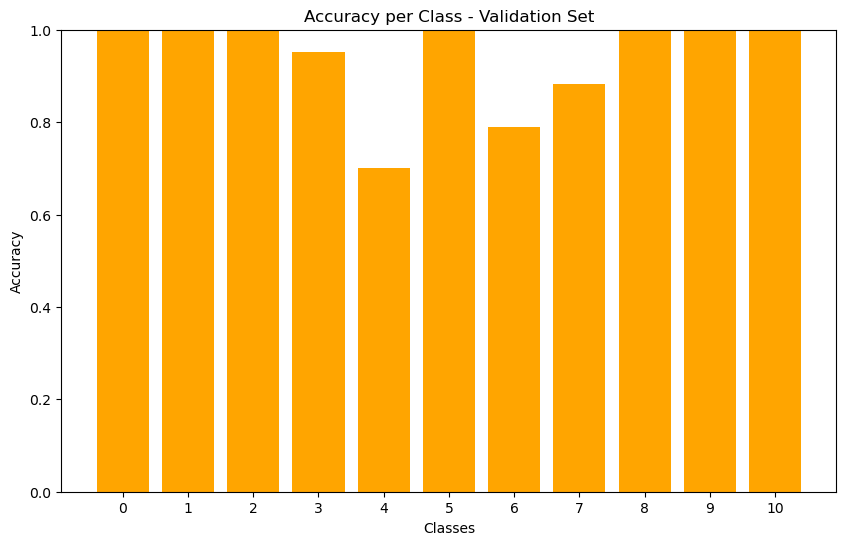

In [16]:
# Função para calcular a acurácia por classe
def accuracy_per_class(y_true, y_pred):
    classes = np.unique(y_true)
    accuracies = []
    for c in classes:
        mask = (y_true == c)
        accuracies.append(np.mean(y_pred[mask] == y_true[mask]))
    return classes, accuracies

# Acurácia por classe no conjunto de treino
classes_train, accuracies_train = accuracy_per_class(y_train_labels, y_pred_train_labels)

# Acurácia por classe no conjunto de validação
classes_val, accuracies_val = accuracy_per_class(y_val_labels, y_pred_val_labels)

# Plotar a acurácia por classe no conjunto de treino
plt.figure(figsize=(10, 6))
plt.bar(classes_train, accuracies_train, color='skyblue')
plt.title('Accuracy per Class - Training Set')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(classes_train)
plt.show()

# Plotar a acurácia por classe no conjunto de validação
plt.figure(figsize=(10, 6))
plt.bar(classes_val, accuracies_val, color='orange')
plt.title('Accuracy per Class - Validation Set')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(classes_val)
plt.show()